# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.7324

947/947 [==============================] - 2710s 3s/step - loss: 0.8159 - accuracy: 0.7324 - val_loss: 8.8223 - val_accuracy: 0.3140
Epoch 2/200
947/947 [==============================] - 2506s 3s/step - loss: 0.7090 - accuracy: 0.7579 - val_loss: 19.3772 - val_accuracy: 0.0322
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.7731

947/947 [==============================] - 2653s 3s/step - loss: 0.6604 - accuracy: 0.7731 - val_loss: 1.8237 - val_accuracy: 0.3854
Epoch 4/200
947/947 [==============================] - 2528s 3s/step - loss: 0.6328 - accuracy: 0.7792 - val_loss: 2.7205 - val_accuracy: 0.5212
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7899

947/947 [==============================] - 2588s 3s/step - loss: 0.6079 - accuracy: 0.7899 - val_loss: 1.4683 - val_accuracy: 0.6489
Epoch 6/200
947/947 [==============================] - 2491s 3s/step - loss: 0.5894 - accuracy: 0.7928 - val_loss: 2.3187 - val_accuracy: 0.4725
Epoch 7/200
947/947 [==============================] - 2499s 3s/step - loss: 0.5715 - accuracy: 0.7978 - val_loss: 1.6187 - val_accuracy: 0.5903
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.8025

947/947 [==============================] - 2581s 3s/step - loss: 0.5612 - accuracy: 0.8025 - val_loss: 1.1604 - val_accuracy: 0.6751
Epoch 9/200
947/947 [==============================] - 2538s 3s/step - loss: 0.5528 - accuracy: 0.8035 - val_loss: 1.3965 - val_accuracy: 0.5788
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.8108

947/947 [==============================] - 2592s 3s/step - loss: 0.5354 - accuracy: 0.8108 - val_loss: 0.9960 - val_accuracy: 0.7461
Epoch 11/200
947/947 [==============================] - 2513s 3s/step - loss: 0.5251 - accuracy: 0.8131 - val_loss: 1.2251 - val_accuracy: 0.6325
Epoch 12/200
947/947 [==============================] - 2503s 3s/step - loss: 0.5170 - accuracy: 0.8189 - val_loss: 1.3814 - val_accuracy: 0.6937
Epoch 13/200
947/947 [==============================] - 2500s 3s/step - loss: 0.5047 - accuracy: 0.8210 - val_loss: 1.1097 - val_accuracy: 0.6590
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.8242

947/947 [==============================] - 2586s 3s/step - loss: 0.4970 - accuracy: 0.8242 - val_loss: 0.8035 - val_accuracy: 0.7578
Epoch 15/200
947/947 [==============================] - 2548s 3s/step - loss: 0.4878 - accuracy: 0.8255 - val_loss: 1.4247 - val_accuracy: 0.7000
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8270

947/947 [==============================] - 2589s 3s/step - loss: 0.4806 - accuracy: 0.8270 - val_loss: 0.7327 - val_accuracy: 0.7583
Epoch 17/200
947/947 [==============================] - 2497s 3s/step - loss: 0.4733 - accuracy: 0.8304 - val_loss: 0.9668 - val_accuracy: 0.7007
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8325

947/947 [==============================] - 2573s 3s/step - loss: 0.4650 - accuracy: 0.8325 - val_loss: 0.6939 - val_accuracy: 0.7637
Epoch 19/200
947/947 [==============================] - 2508s 3s/step - loss: 0.4542 - accuracy: 0.8359 - val_loss: 0.8172 - val_accuracy: 0.7523
Epoch 20/200
947/947 [==============================] - 2498s 3s/step - loss: 0.4492 - accuracy: 0.8387 - val_loss: 0.8857 - val_accuracy: 0.7308
Epoch 21/200
947/947 [==============================] - 2495s 3s/step - loss: 0.4441 - accuracy: 0.8411 - val_loss: 0.7069 - val_accuracy: 0.7752
Epoch 22/200
947/947 [==============================] - 2506s 3s/step - loss: 0.4400 - accuracy: 0.8439 - val_loss: 0.8069 - val_accuracy: 0.7424
Epoch 23/200
947/947 [==============================] - 2497s 3s/step - loss: 0.4298 - accuracy: 0.8464 - val_loss: 0.7082 - val_accuracy: 0.7718
Epoch 24/200
947/947 [==============================] - 2500s 3s/step - loss: 0.4244 - accuracy: 0.8479 - val_loss: 0.9518 - val_accuracy

947/947 [==============================] - 2593s 3s/step - loss: 0.4122 - accuracy: 0.8517 - val_loss: 0.6171 - val_accuracy: 0.7995
Epoch 27/200
947/947 [==============================] - 2493s 3s/step - loss: 0.4057 - accuracy: 0.8539 - val_loss: 0.7777 - val_accuracy: 0.7704
Epoch 28/200
947/947 [==============================] - 2499s 3s/step - loss: 0.3957 - accuracy: 0.8582 - val_loss: 0.6193 - val_accuracy: 0.7966
Epoch 29/200
947/947 [==============================] - 2494s 3s/step - loss: 0.3923 - accuracy: 0.8595 - val_loss: 0.6936 - val_accuracy: 0.7542
Epoch 30/200
947/947 [==============================] - 2496s 3s/step - loss: 0.3862 - accuracy: 0.8609 - val_loss: 0.7198 - val_accuracy: 0.7759
Epoch 31/200
947/947 [==============================] - 2496s 3s/step - loss: 0.3848 - accuracy: 0.8607 - val_loss: 0.7955 - val_accuracy: 0.7670
Epoch 32/200
947/947 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8642

947/947 [==============================] - 2587s 3s/step - loss: 0.3745 - accuracy: 0.8642 - val_loss: 0.5833 - val_accuracy: 0.7922
Epoch 33/200
947/947 [==============================] - 2494s 3s/step - loss: 0.3716 - accuracy: 0.8655 - val_loss: 0.7401 - val_accuracy: 0.7765
Epoch 34/200
947/947 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8652

947/947 [==============================] - 2588s 3s/step - loss: 0.3681 - accuracy: 0.8652 - val_loss: 0.5816 - val_accuracy: 0.8156
Epoch 35/200
947/947 [==============================] - 2484s 3s/step - loss: 0.3641 - accuracy: 0.8671 - val_loss: 0.6074 - val_accuracy: 0.8180
Epoch 36/200
947/947 [==============================] - 2491s 3s/step - loss: 0.3551 - accuracy: 0.8715 - val_loss: 0.6537 - val_accuracy: 0.8010
Epoch 37/200
947/947 [==============================] - 2495s 3s/step - loss: 0.3546 - accuracy: 0.8697 - val_loss: 0.7248 - val_accuracy: 0.7976
Epoch 38/200
947/947 [==============================] - 2480s 3s/step - loss: 0.3442 - accuracy: 0.8751 - val_loss: 1.4213 - val_accuracy: 0.6604
Epoch 39/200
947/947 [==============================] - 2495s 3s/step - loss: 0.3459 - accuracy: 0.8749 - val_loss: 0.7705 - val_accuracy: 0.7558
Epoch 40/200
947/947 [==============================] - 2479s 3s/step - loss: 0.3337 - accuracy: 0.8782 - val_loss: 0.7145 - val_accuracy

947/947 [==============================] - 2586s 3s/step - loss: 0.3225 - accuracy: 0.8823 - val_loss: 0.5157 - val_accuracy: 0.8218
Epoch 45/200
947/947 [==============================] - 2472s 3s/step - loss: 0.3170 - accuracy: 0.8842 - val_loss: 0.8506 - val_accuracy: 0.7659
Epoch 46/200
947/947 [==============================] - 2495s 3s/step - loss: 0.3135 - accuracy: 0.8866 - val_loss: 0.7691 - val_accuracy: 0.8080
Epoch 47/200
947/947 [==============================] - 2496s 3s/step - loss: 0.3029 - accuracy: 0.8882 - val_loss: 0.9425 - val_accuracy: 0.7259
Epoch 48/200
947/947 [==============================] - 2481s 3s/step - loss: 0.3075 - accuracy: 0.8868 - val_loss: 0.7147 - val_accuracy: 0.7780
Epoch 49/200
947/947 [==============================] - 2494s 3s/step - loss: 0.2998 - accuracy: 0.8899 - val_loss: 1.0169 - val_accuracy: 0.7612
Epoch 50/200
947/947 [==============================] - 2492s 3s/step - loss: 0.2953 - accuracy: 0.8926 - val_loss: 0.5879 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 303s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.962066876665859,
 'basal cell carcinoma': 0.9826336851331642,
 'dermatofibroma': 0.9627730489180596,
 'melanoma': 0.9282062017299281,
 'nevus': 0.9615692064096812,
 'pigmented benign keratosis': 0.9737090673520992,
 'seborrheic keratosis': 0.9474238118569329,
 'solar lentigo': 0.9551036682615629,
 'squamous cell carcinoma': 0.9651056123619051,
 'vascular lesion': 0.9686617189370362}

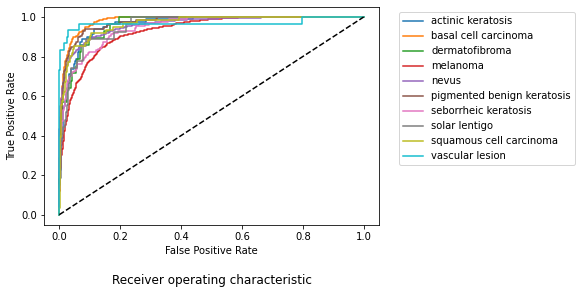

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

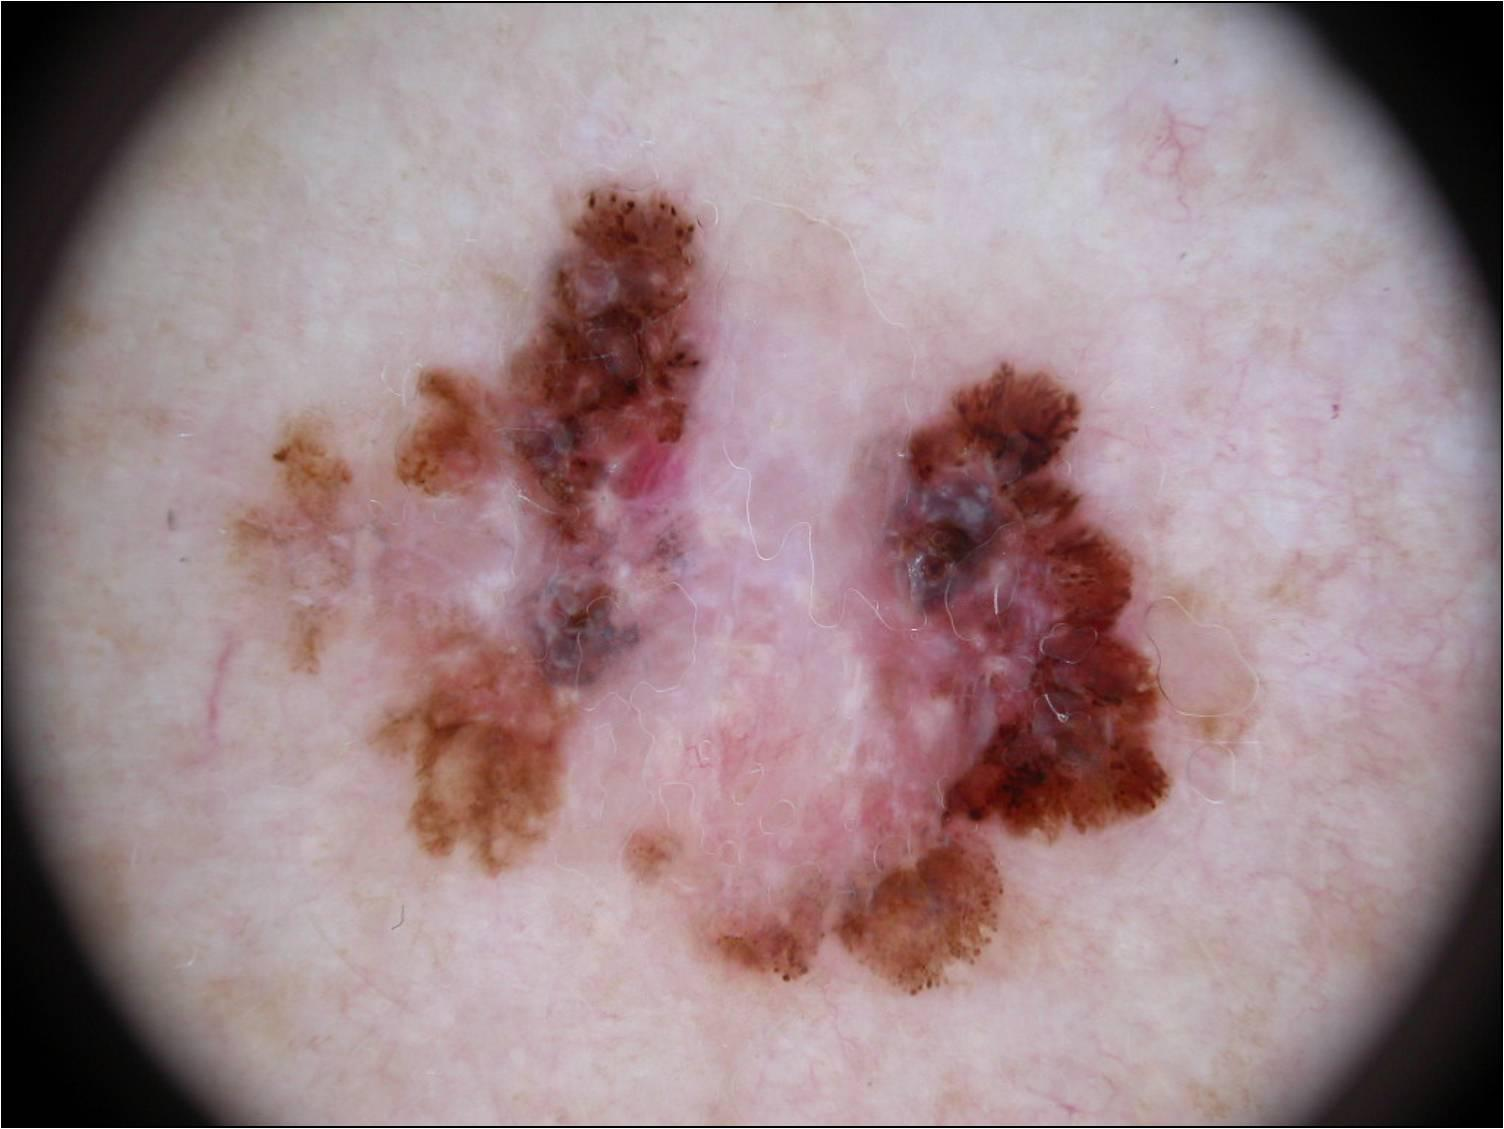

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

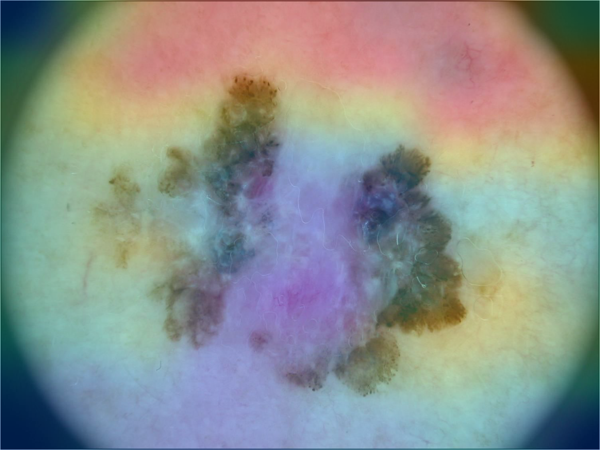

In [23]:
display_gradcam(melanoma_im_path, heatmap)